# LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from itertools import product

from tqdm import tqdm

In [2]:
WITH_QRELS = 'text_summarized_200.csv'

INPUT_FILE_STEP_1 = 'ranking/v3_train_scores.txt'
INPUT_FILE_STEP_2 = 'ranking/HIGH_train_scores.txt'

In [3]:

scores = pd.read_csv(INPUT_FILE_STEP_1).set_index(['case_id', 'candidate_id'])
original = pd.read_csv(WITH_QRELS).set_index(['case_id', 'candidate_id'])
full_mix = scores.join(original).reset_index()[['case_id', 'candidate_id', 'score', 'candidate_is_noticed']]

# Restrict to only the test cases
test_cases = pd.read_csv('test_cases_id.csv', names=['case_id'], header=None).set_index('case_id')
test_mix = full_mix.set_index('case_id').join(test_cases, how='inner').reset_index()
train_mix = full_mix[~full_mix['case_id'].isin(test_cases.reset_index()['case_id'])].reset_index()

high_scores = pd.read_csv(INPUT_FILE_STEP_2).set_index(['case_id', 'candidate_id'])
high_full_mix = high_scores.join(original).reset_index()[['case_id', 'candidate_id', 'score', 'candidate_is_noticed']]
high_test_mix = high_full_mix.set_index('case_id').join(test_cases, how='inner').reset_index()
high_train_mix = high_full_mix[~high_full_mix['case_id'].isin(test_cases.reset_index()['case_id'])].reset_index()


number_cases = len(test_mix['case_id'].unique())
number_candidates= 200

print('mix: {}'.format(test_mix.shape))
print('Number of cases: {}'.format(number_cases))

nb_rels = {}
for case_id, rel in test_mix[test_mix['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
    nb_rels[case_id] = rel
print('Average number of rels per case: {:0.2f}'.format(np.mean([v for _,v in nb_rels.items()])))

mix: (14400, 4)
Number of cases: 72
Average number of rels per case: 4.21


# VIZ

## Distribution of RELS per case

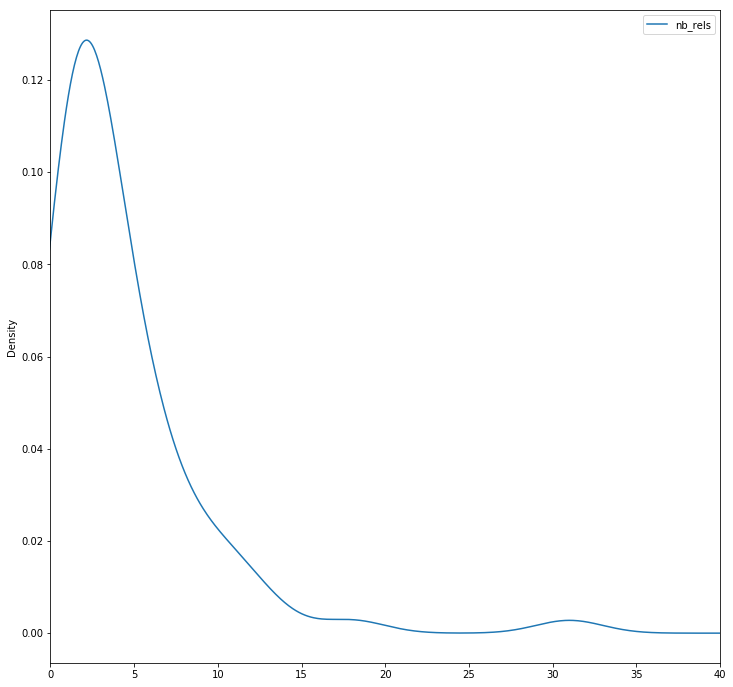

In [4]:
rels_df = pd.DataFrame.from_dict(nb_rels, orient='index', columns=['nb_rels'])
_ = rels_df.plot.kde(xlim=(0,40), figsize=(12,12))

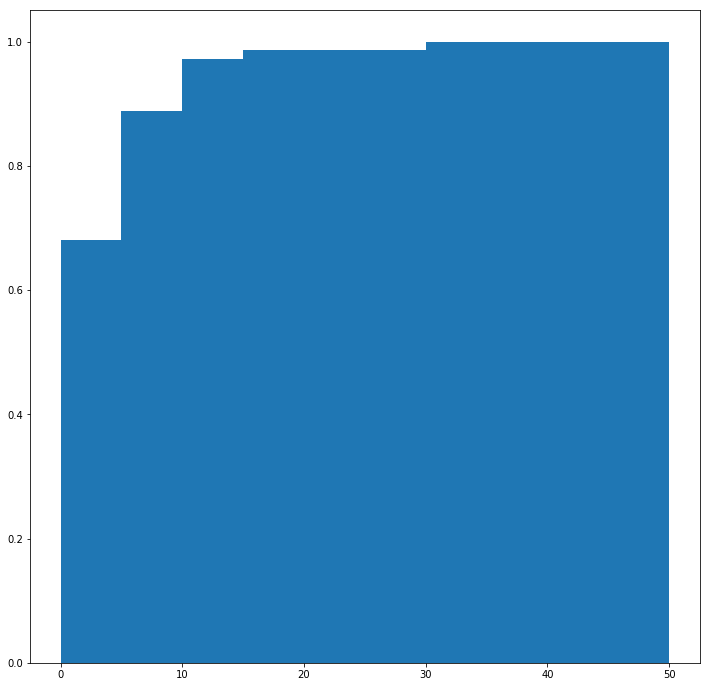

In [8]:
plt.figure(figsize=(12,12))
_ = plt.hist(x=rels_df['nb_rels'], bins=[i*5 for i in range(0,11)], density=True, cumulative=True)

## For the test data, the distribution of scores with regards to the true class

In [ ]:
_ = test_mix[test_mix['candidate_is_noticed'] == True]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='blue', figsize=(12,12))


In [ ]:
_ = test_mix[test_mix['candidate_is_noticed'] == False]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='orange',  figsize=(12,12))


## For the TRAIN data, separate plots for POSITIVE class / NEGATIVE class

In [ ]:
sample_train = train_mix
_ = sample_train[sample_train['candidate_is_noticed'] == True]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='blue', figsize=(12,12))


In [ ]:
_ = sample_train[sample_train['candidate_is_noticed'] == False]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='orange',  figsize=(12,12))


# CUTTING BY SCORE

## Final Score based on 2-step

Final result list : all in Step 1 with score more than cut_01 and less than 0.9 + all in Step 2 with score more than cut_02

In [14]:
NB_BINS = 200
all_cuts = product(np.arange(0.0, 1.0, 1.0/NB_BINS), repeat=2)
cuts = []

mix_results = test_mix.set_index(['case_id', 'candidate_id']).join(high_test_mix.set_index(['case_id', 'candidate_id']), how='left', lsuffix='_01', rsuffix='_02').reset_index()
mix_results['candidate_is_noticed'] = mix_results['candidate_is_noticed_01']
mix_results = mix_results.drop(columns=['candidate_is_noticed_01', 'candidate_is_noticed_02'])

for cut_01, cut_02 in tqdm(all_cuts, total=NB_BINS**2):
    results = mix_results[(mix_results['score_01'] > cut_01) & ((mix_results['score_01'] < 0.9) | (mix_results['score_02'] > cut_02))]
    
    # Final result list: 
    
    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        nb_found = {}
        nb_returned = {}

        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p) if (avg_r + avg_p) > 0 else 0

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut_01, cut_02, avg_r, avg_p, avg_f1])

score_cuts_df = pd.DataFrame(cuts, columns=['cut_01', 'cut_02', 'r', 'p', 'f1'])


100%|██████████| 40000/40000 [02:29<00:00, 267.50it/s]


Best cut for r: 
   cut_01  cut_02    r
0     0.0     0.0  1.0

Best cut for p: 
       cut_01  cut_02    p
37769    0.94   0.845  1.0

Best cut for f1: 
       cut_01  cut_02        f1
39111   0.975   0.555  0.563327



In [27]:
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, score_cuts_df.sort_values(metric, ascending=False)[:1]))

Best cut for r: 
   cut_01  cut_02    r         p        f1
0     0.0     0.0  1.0  0.021042  0.041216

Best cut for p: 
       cut_01  cut_02         r    p        f1
37769    0.94   0.845  0.066007  1.0  0.123839

Best cut for f1: 
       cut_01  cut_02         r         p        f1
39111   0.975   0.555  0.491749  0.659292  0.563327



# CUTTING BY RANK

In [10]:
ranked_01 = test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked_01['rank'] = ranked_01.groupby('case_id')['score'].rank(ascending=False)
ranked_02 = high_test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked_02['rank'] = ranked_02.groupby('case_id')['score'].rank(ascending=False)

mix_results = ranked_01.set_index(['case_id', 'candidate_id']).join(ranked_02.set_index(['case_id', 'candidate_id']), how='left', lsuffix='_01', rsuffix='_02').reset_index()
mix_results['candidate_is_noticed'] = mix_results['candidate_is_noticed_01']
mix_results = mix_results.drop(columns=['candidate_is_noticed_01', 'candidate_is_noticed_02'])

cuts = []
all_cuts = product(np.arange(1, number_candidates+1, 1), repeat=2)

for cut_01, cut_02 in tqdm(all_cuts, total=number_candidates**2):
    results = mix_results[(mix_results['rank_01'] <= cut_01) & ((mix_results['score_01'] < 0.9) | (mix_results['rank_02'] <= cut_02))]

    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        nb_found = {}
        nb_returned = {}

        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

            # MACRO Average
            #avg_r = sum([v for _,v in recall.items()]) / len(recall)
            #avg_p = sum([v for _,v in precision.items()]) / len(precision)
            #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p)

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut_01, cut_02, avg_r, avg_p, avg_f1])

rank_cuts_df = pd.DataFrame(cuts, columns=['cut_01', 'cut_02', 'r', 'p', 'f1'])

100%|██████████| 40000/40000 [02:40<00:00, 248.58it/s]

Best cut for r: 
       cut_01  cut_02    r
39999     200     200  1.0

Best cut for p: 
   cut_01  cut_02         p
0       1       1  0.891304

Best cut for f1: 
      cut_01  cut_02        f1
1208       7       9  0.500763



In [28]:
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, rank_cuts_df.sort_values(metric, ascending=False)[:1]))

Best cut for r: 
       cut_01  cut_02    r         p        f1
39999     200     200  1.0  0.021042  0.041216

Best cut for p: 
   cut_01  cut_02         r         p        f1
0       1       1  0.135314  0.891304  0.234957

Best cut for f1: 
      cut_01  cut_02         r         p        f1
1208       7       9  0.541254  0.465909  0.500763



# CUTTING BY RANK AND SCORE

In [13]:
ranked_01 = test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked_01['rank'] = ranked_01.groupby('case_id')['score'].rank(ascending=False)
ranked_02 = high_test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked_02['rank'] = ranked_02.groupby('case_id')['score'].rank(ascending=False)

mix_results = ranked_01.set_index(['case_id', 'candidate_id']).join(ranked_02.set_index(['case_id', 'candidate_id']), how='left', lsuffix='_01', rsuffix='_02').reset_index()
mix_results['candidate_is_noticed'] = mix_results['candidate_is_noticed_01']
mix_results = mix_results.drop(columns=['candidate_is_noticed_01', 'candidate_is_noticed_02'])

cuts = []
all_cuts = product(np.arange(1, number_candidates+1, 1), np.arange(0.0, 1.0, 1.0/NB_BINS))

for cut_01, cut_02 in tqdm(all_cuts, total=NB_BINS*number_candidates):
    results = mix_results[(mix_results['rank_01'] <= cut_01) & ((mix_results['score_01'] < 0.9) | (mix_results['score_02'] > cut_02))]

    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        nb_found = {}
        nb_returned = {}

        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

            # MACRO Average
            #avg_r = sum([v for _,v in recall.items()]) / len(recall)
            #avg_p = sum([v for _,v in precision.items()]) / len(precision)
            #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p) if avg_r + avg_r > 0 else 0

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut_01, cut_02, avg_r, avg_p, avg_f1])

score_rank_cuts_df = pd.DataFrame(cuts, columns=['cut_01', 'cut_02', 'r', 'p', 'f1'])

100%|██████████| 40000/40000 [02:39<00:00, 250.46it/s]


Best cut for r: 
       cut_01  cut_02    r
35600     179     0.0  1.0

Best cut for p: 
     cut_01  cut_02    p
372       2    0.86  1.0

Best cut for f1: 
      cut_01  cut_02    f1
1900      10     0.5  0.56



In [29]:
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, score_rank_cuts_df.sort_values(metric, ascending=False)[:1]))

Best cut for r: 
       cut_01  cut_02    r        p       f1
35600     179     0.0  1.0  0.02351  0.04594

Best cut for p: 
     cut_01  cut_02         r    p        f1
372       2    0.86  0.026403  1.0  0.051447

Best cut for f1: 
      cut_01  cut_02         r         p    f1
1900      10     0.5  0.485149  0.662162  0.56



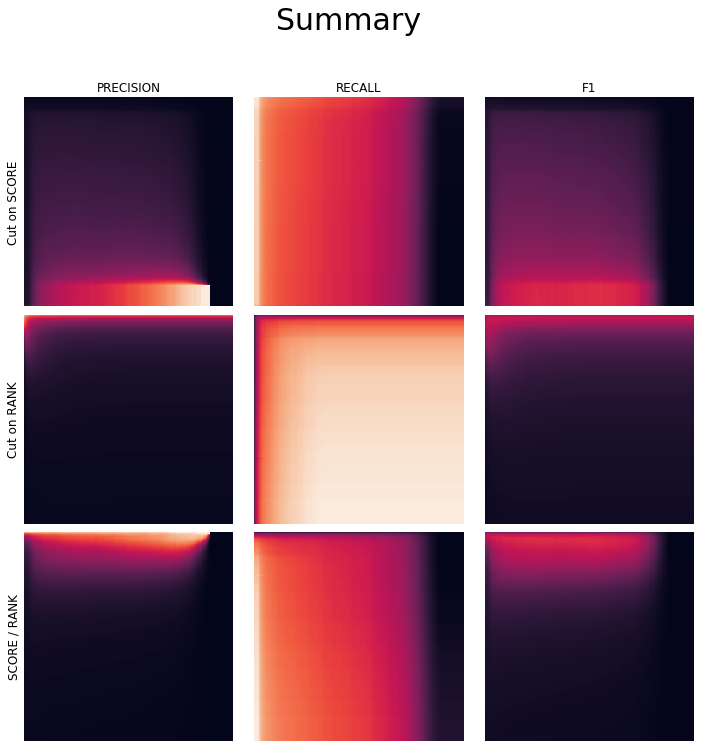

In [23]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=3, ncols=4)
fig.suptitle("Summary", fontsize=30)
fig.set_size_inches(12, 12)

#divider = make_axes_locatable(axes[0,2])
#cax = divider.append_axes("right", "5%", pad="3%")

_ = sns.heatmap(score_cuts_df.pivot('cut_01', 'cut_02', 'p').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[0,0], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(score_cuts_df.pivot('cut_01', 'cut_02', 'r').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[0,1], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(score_cuts_df.pivot('cut_01', 'cut_02', 'f1').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[0,2], cbar=False, xticklabels=False, yticklabels=False)

#divider = make_axes_locatable(axes[1,2])
#cax = divider.append_axes("right", "5%", pad="3%")

_ = sns.heatmap(rank_cuts_df.pivot('cut_01', 'cut_02', 'p').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[1,0], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(rank_cuts_df.pivot('cut_01', 'cut_02', 'r').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[1,1], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(rank_cuts_df.pivot('cut_01', 'cut_02', 'f1').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[1,2], cbar=False, xticklabels=False, yticklabels=False)

#divider = make_axes_locatable(axes[2,2])
#cax = divider.append_axes("right", "5%", pad="3%")

_ = sns.heatmap(score_rank_cuts_df.pivot('cut_01', 'cut_02', 'p').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[2,0], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(score_rank_cuts_df.pivot('cut_01', 'cut_02', 'r').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[2,1], cbar=False, xticklabels=False, yticklabels=False)
_ = sns.heatmap(score_rank_cuts_df.pivot('cut_01', 'cut_02', 'f1').to_numpy(), square=True, vmin=0.0, vmax=1.0, ax=axes[2,2], cbar=False, xticklabels=False, yticklabels=False)

fig.subplots_adjust(hspace=0, wspace=0.1)

cols = ['PRECISION', 'RECALL', 'F1']
rows = ['Cut on SCORE', 'Cut on RANK', 'SCORE / RANK']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.show()

In [34]:
NB_BINS = 1000
all_cuts = np.arange(0.0, 1.0, 1.0/NB_BINS)
cuts = []

mix_results = test_mix.set_index(['case_id', 'candidate_id']).join(high_test_mix.set_index(['case_id', 'candidate_id']), how='left', lsuffix='_01', rsuffix='_02').reset_index()
mix_results['candidate_is_noticed'] = mix_results['candidate_is_noticed_01']
mix_results = mix_results.drop(columns=['candidate_is_noticed_01', 'candidate_is_noticed_02'])

for cut_02 in tqdm(all_cuts, total=NB_BINS):
    results = mix_results[mix_results['score_02'] > cut_02]
    
    # Final result list: 
    
    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        nb_found = {}
        nb_returned = {}

        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p) if (avg_r + avg_p) > 0 else 0

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut_02, avg_r, avg_p, avg_f1])

re_score_cuts_df = pd.DataFrame(cuts, columns=['cut_02', 'r', 'p', 'f1'])


100%|██████████| 1000/1000 [00:02<00:00, 354.24it/s]


In [35]:
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, re_score_cuts_df.sort_values(metric, ascending=False)[:1]))

Best cut for r: 
   cut_02         r         p        f1
0     0.0  0.917492  0.076605  0.141404

Best cut for p: 
     cut_02         r    p        f1
872   0.872  0.016502  1.0  0.032468

Best cut for f1: 
     cut_02         r         p        f1
559   0.559  0.491749  0.662222  0.564394



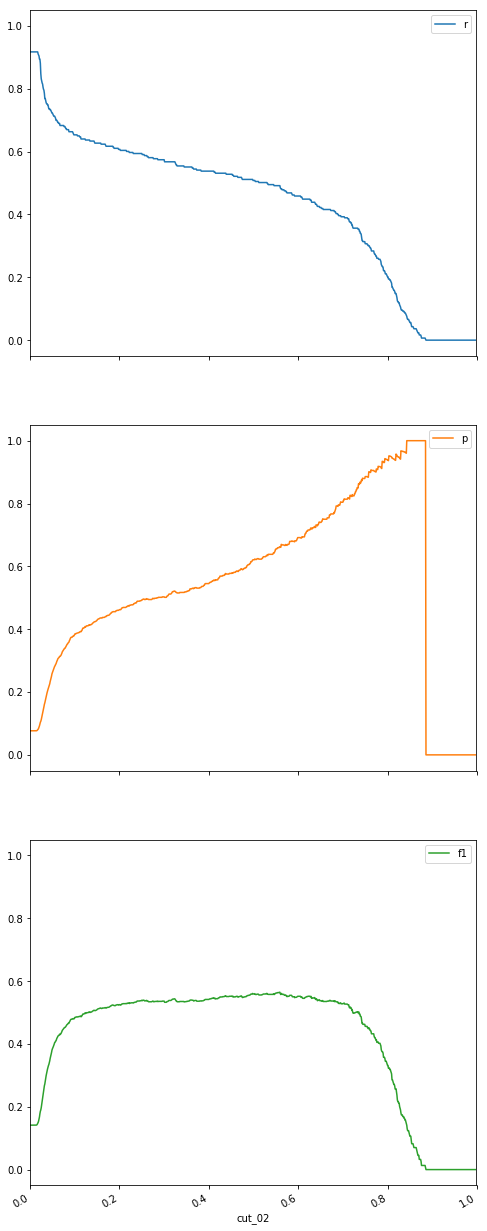

In [37]:
_ = re_score_cuts_df.plot(x='cut_02', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(8,24))